In [1]:
# point of this notebook is to look at where our probe predictions are failing or succeeding. We want to diagnose an overconfident probe

In [1]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc, classification_report


In [38]:
# LABELLED_DATASET="GSM8K_SR"
LABELLED_DATASET="MATH_learnability"
PROBING_MODEL_ALIAS="Qwen2.5-Math-1.5B-Instruct"
PROBE_TARGET_MODEL_ALIAS="Qwen2.5-Math-1.5B-Instruct"
PROBE_DATA_PATH = f"../runs/{PROBING_MODEL_ALIAS}/generate_svs/predicting_{LABELLED_DATASET}_{PROBE_TARGET_MODEL_ALIAS}_max_3000_k_1_temp_0.0/best_probe_predictions.json"


In [39]:
with open(PROBE_DATA_PATH, "r") as f:
    PROBE_DATA = json.load(f)

In [40]:
TEST_ACTUAL = PROBE_DATA["test_actual"]
TEST_PREDICTED = PROBE_DATA["test_predictions"]

In [41]:
TEST_PASS_1 = sum(TEST_ACTUAL)/len(TEST_ACTUAL)
print(f"Test Accuracy: {TEST_PASS_1}")


Test Accuracy: 0.74


In [42]:
print(f"auc score: {roc_auc_score(TEST_ACTUAL, TEST_PREDICTED)}")

auc score: 0.8600831600831601


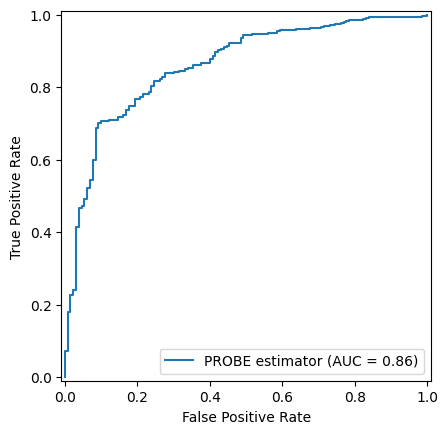

In [43]:
fpr, tpr, thresholds = roc_curve(TEST_ACTUAL, TEST_PREDICTED)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name='PROBE estimator')
display.plot()

In [20]:
CHOSEN_THRESHOLD = 0.5
TEST_PREDICTED_THRESHOLDED = [1 if x >= CHOSEN_THRESHOLD else 0 for x in TEST_PREDICTED]

In [21]:
cr = classification_report(TEST_ACTUAL, TEST_PREDICTED_THRESHOLDED)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.51      0.61       130
           1       0.84      0.94      0.89       370

    accuracy                           0.83       500
   macro avg       0.80      0.72      0.75       500
weighted avg       0.82      0.83      0.82       500



Text(0.5, 1.02, 'Probe Model: Qwen2.5-Math-1.5B-Instruct, Dataset: MATH_learnability')

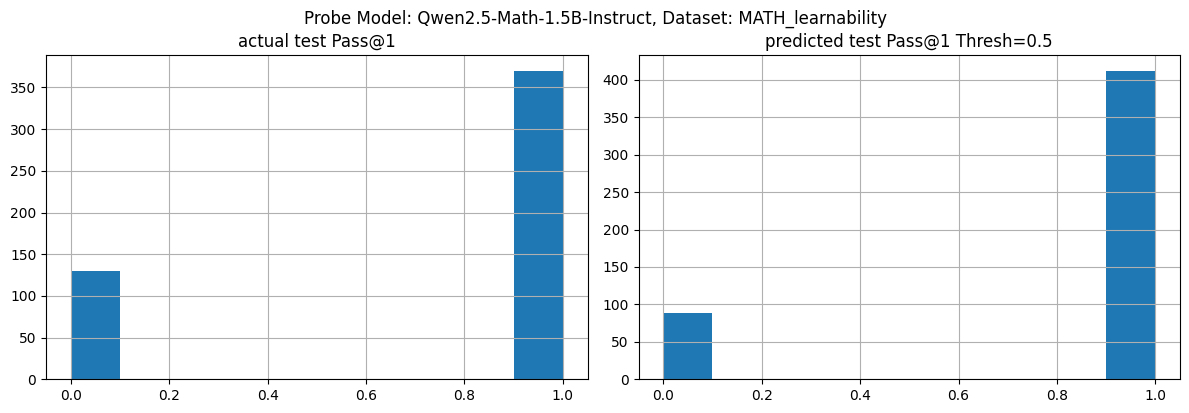

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.DataFrame(TEST_ACTUAL).hist(ax=axes[0])
axes[0].set_title(f"actual test Pass@1")

pd.DataFrame(TEST_PREDICTED_THRESHOLDED).hist(ax=axes[1])
axes[1].set_title(f"predicted test Pass@1 Thresh={CHOSEN_THRESHOLD}")

plt.tight_layout()
plt.suptitle(f"Probe Model: {PROBING_MODEL_ALIAS}, Dataset: {LABELLED_DATASET}", y=1.02)

In [23]:
cr = classification_report(TEST_ACTUAL, TEST_PREDICTED_THRESHOLDED)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.51      0.61       130
           1       0.84      0.94      0.89       370

    accuracy                           0.83       500
   macro avg       0.80      0.72      0.75       500
weighted avg       0.82      0.83      0.82       500



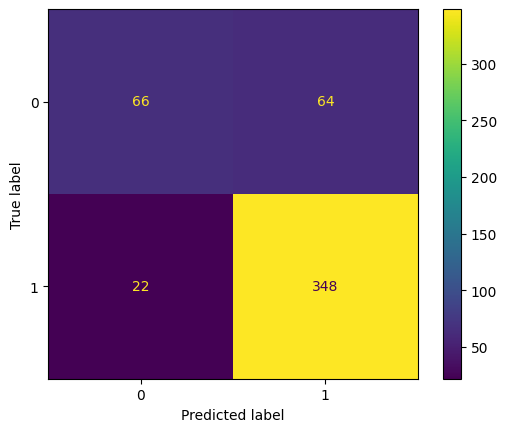

In [24]:
cm = confusion_matrix(TEST_ACTUAL, TEST_PREDICTED_THRESHOLDED)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [15]:
# Seems like the small model is good at predicting the ones it will fail.
# Prediction performance for the problems we fail seems to go down as we expand on model complexity.

## SANITY CHECKING UNSUPERVISED LABELLING

In [35]:
UNSUP_DATA_PATH = "../runs/Qwen2.5-Math-1.5B-Instruct/datasplits/E2H-GSM8K_predicted_by_predicting_MATH_learnability_Qwen2.5-Math-1.5B-Instruct_max_3000_k_1_temp_0.0.json"

SR_DATA_PATH = ""


In [36]:
unsup_df = pd.read_json(UNSUP_DATA_PATH)

In [37]:
unsup_df["predicted_difficulty"].describe()

count    1319.000000
mean       -1.415236
std         3.554193
min       -14.924369
25%        -3.804402
50%        -1.308610
75%         1.174896
max         8.131352
Name: predicted_difficulty, dtype: float64

In [38]:
unsup_df["predicted_difficulty_sigmoid"].describe()

count    1.319000e+03
mean     3.737543e-01
std      3.722902e-01
min      3.299353e-07
25%      2.178743e-02
50%      2.127195e-01
75%      7.640285e-01
max      9.997059e-01
Name: predicted_difficulty_sigmoid, dtype: float64

<Axes: >

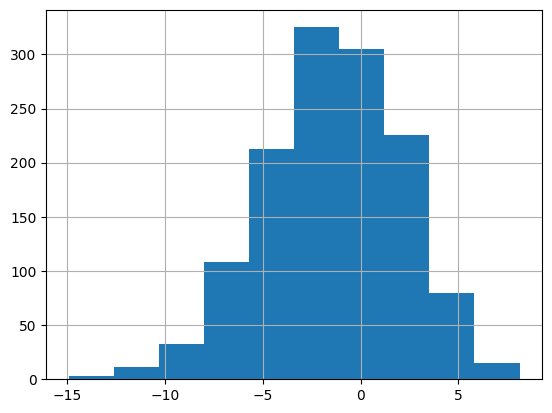

In [39]:
unsup_df["predicted_difficulty"].hist()

<Axes: >

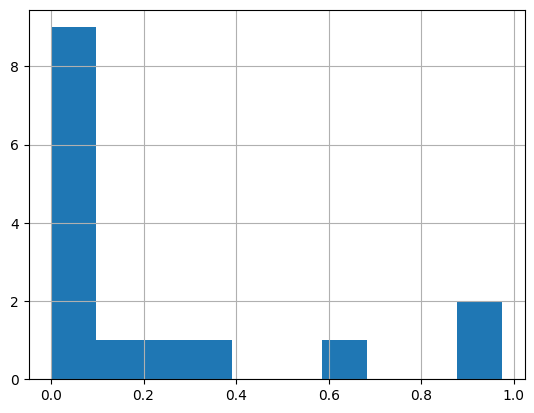

In [34]:
unsup_df["predicted_difficulty_sigmoid"].hist()